## Obtain spectra for the sources and add additional spec-zs from SIMBAD

In [120]:
%matplotlib inline
import sys, os, glob, copy, shutil

from astropy.io import fits, ascii

import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
import astropy.constants as const
from astropy.coordinates import SkyCoord, concatenate
from astropy import table
import scienceplots

plt.style.use(['bright', 'science', 'no-latex', 'notebook'])

In [121]:
# A token is needed to access ADS and it locates at https://ui.adsabs.harvard.edu/user/settings/token

from astroquery import nasa_ads as na

na.ADS.TOKEN = 'Gh2X1K7QxOgpUq0kU3eG3QWNuer5wV6CaIjgkGdp'
na.ADS.NROWS = 20
na.ADS.SORT = 'bibcode desc'
na.ADS.ADS_FIELDS = ['author','title','pubdate', 'bibcode'] # 'bibcode' must be in the field
def get_ref(bibcode): 
    results = na.ADS.query_simple('bibcode:'+bibcode)
    author = results['author'][0][0].split(',')[0]
    year = results['pubdate'][0][0:4]
    return author + year

# try it
#get_ref('2013ApJ...767..118C')

### Read the HSC-SSP AGN table

https://ui.adsabs.harvard.edu/abs/2020ApJ...894...24K/abstract

In [122]:
# Read HSC-SSP AGNs
data_agn = ascii.read('hsc_agn.txt')
cat_agn = SkyCoord(data_agn['RAdeg'], data_agn['DEdeg'], unit='deg')
# data_agn

1: spectroscopic redshift from the HSC catalog,

2: spectroscopic redshift from the DEIMOS catalog,

3: photometric redshift from z_best in the Chandra catalog,

4: photometric redshift from ZPDF in the COSMOS2015 catalog.

There are still more with spectra than it appears this table!

Prepare the updated table by copying and adding extra columns:
```
Original (Copy)     -> z4
Original DEIMOS     -> z2
Original Chandra    -> z5
Original HSC        -> X (outdated DR2)
Original COSMOS2015 -> X (outdated phot-z)
SIMBAD              -> z0
HSC DR3             -> z1
COSMOS2020          -> z3
```

In [123]:
data_agn_updated = copy.deepcopy(data_agn)
data_agn_updated['z4'] = data_agn['z']
data_agn_updated['r_z4'] = data_agn['r_z']
data_agn_updated['z'] = -1.
data_agn_updated['r_z'] = -1

data_agn_updated['z2'] = -1. 
for i in range(len(data_agn)): 
    if data_agn['r_z'][i]==2: 
        data_agn_updated['z2'][i] = data_agn['z'][i]

data_agn_updated['z5'] = -1. 
for i in range(len(data_agn)): 
    if data_agn['r_z'][i]==3: 
        data_agn_updated['z5'][i] = data_agn['z'][i]

data_agn_updated[164-1]

ID,RAdeg,DEdeg,i-mag,X-flag,g-flag,r-flag,i-flag,z-flag,n-corr,z,r_z,ID-COSMOS2015,z4,r_z4,z2,z5
--,deg,deg,mag,--,--,--,--,--,--,--,--,--,--,--,,
int32,float64,float64,float64,int32,int32,int32,int32,int32,int32,float64,int32,int32,float64,int32,float64,float64
164,150.22416,2.65113,22.64,1,1,1,1,1,6,-1.0,-1,890192,1.749,3,-1.0,1.749


In [124]:
data_agn_updated[164-1]

ID,RAdeg,DEdeg,i-mag,X-flag,g-flag,r-flag,i-flag,z-flag,n-corr,z,r_z,ID-COSMOS2015,z4,r_z4,z2,z5
--,deg,deg,mag,--,--,--,--,--,--,--,--,--,--,--,,
int32,float64,float64,float64,int32,int32,int32,int32,int32,int32,float64,int32,int32,float64,int32,float64,float64
164,150.22416,2.65113,22.64,1,1,1,1,1,6,-1.0,-1,890192,1.749,3,-1.0,1.749


### Only keep Chandra redshifts which are specz in Kimura20

The table Kimura20 used: 

https://irsa.ipac.caltech.edu/data/COSMOS/tables/chandra/

chandra_COSMOS_legacy_opt_NIR_counterparts_20160113_4d.fits

In [125]:
data_chandra = table.Table.read('spec/chandra_COSMOS_legacy_opt_NIR_counterparts_20160113_4d.fits')
cat_chandra = SkyCoord(data_chandra['RA_x'], data_chandra['DEC_x'], unit='deg')
data_chandra_specz = data_chandra[data_chandra['z_spec']!=-99]
cat_chandra_specz = SkyCoord(data_chandra_specz['RA_x'], data_chandra_specz['DEC_x'], unit='deg')

idx_chandra, idx_agn, d2d, d3d = cat_agn.search_around_sky(cat_chandra_specz, 0.5*u.arcsec)

print('total matched: ', len(cat_agn.search_around_sky(cat_chandra, 0.5*u.arcsec)[0]))
print('specz: ', len(idx_chandra))

# delete photz in chandra catalog

data_agn_updated['z5'] = -1. 
for i in range(len(data_agn)): 
    if data_agn['r_z'][i]==3: 
        data_agn_updated['z5'][i] = data_agn['z'][i]

print('total', np.count_nonzero(data_agn_updated['z5']!=-1.), 'Chandra z')

cnt_deleted = 0
for i in range(491): 
    if ~np.isin(i, idx_agn) and data_agn_updated['z5'][i]!=-1.: 
        cnt_deleted+=1
        data_agn_updated['z5'][i] = -1

print('deleted', cnt_deleted, 'photz')


total matched:  313
specz:  291
total 123 Chandra z
deleted 65 photz


### Match to SIMBAD using `astroquery`

Description for `add_votable_fields` refers to:  
https://github.com/astropy/astroquery/blob/main/astroquery/simbad/data/votable_fields_dict.json

In [126]:
from astroquery.simbad import Simbad

# Add the redshift information
customSimbad = Simbad()
customSimbad.add_votable_fields('rvz_qual','rvz_wavelength','z_value', 'rvz_bibcode', 'flux(i)')

result_table = customSimbad.query_region(cat_agn, radius=0.5*u.arcsec)

# Sources with RVZ_WAVELENGTH == 'O' and rvz_qual!='E' should have an optical spectrum
mask_spec_simbad = ((result_table['RVZ_WAVELENGTH']=='O') | (result_table['RVZ_WAVELENGTH']=='N'))  & (result_table['RVZ_QUAL']!='E') 

result_table.write('result_table.txt', format='csv', overwrite=True)

c:\Users\Chisen\.conda\envs\py39\lib\site-packages\astroquery\simbad\core.py:135: UserWarning: Warning: The script line number 89 raised an error (recorded in the `errors` attribute of the result table): '10:01:58.956 +2:24:45.216': No astronomical object found :  
  warnings.warn("Warning: The script line number %i raised "


add result into updated table (bibcode incomplete)

In [127]:
simbad_bibcodes, _ = np.unique(result_table[mask_spec_simbad]['RVZ_BIBCODE'], return_counts=True)

data_agn_updated['z0'] = -1.
data_agn_updated['r_z0'] = -1

idx = result_table['SCRIPT_NUMBER_ID'].data.data - 1
idx_simbad_specz = idx[mask_spec_simbad]

simbad_rz_codes = {}
for i, bibcode in enumerate(simbad_bibcodes): 
    simbad_rz_codes.update({bibcode: i+1})

for j,i in enumerate(idx_simbad_specz):
    data_agn_updated['z0'][i] = result_table[mask_spec_simbad]['Z_VALUE'][j]
    data_agn_updated['r_z0'][i] = simbad_rz_codes[result_table[mask_spec_simbad]['RVZ_BIBCODE'][j]]

In [128]:
simbad_rz_codes

{'2007ApJS..172...70L': 1,
 '2009ApJ...693....8B': 2,
 '2009ApJ...696.1195T': 3,
 '2012ApJ...753..121K': 4,
 '2012ApJ...758...47A': 5,
 '2012ApJS..203...21A': 6,
 '2014A&A...563A..54P': 7,
 '2014MNRAS.443.2679B': 8,
 '2015ApJ...806L..35K': 9,
 '2015ApJS..219...12A': 10,
 '2015ApJS..220...12S': 11,
 '2016ApJ...822...42O': 12,
 '2016MNRAS.456.1195H': 13,
 '2016MNRAS.458.4321K': 14,
 '2017MNRAS.467.1965H': 15,
 '2018A&A...611A..53J': 16,
 '2018A&A...613A..51P': 17,
 '2018ApJ...858...77H': 18,
 '2018ApJ...869...20B': 19,
 '2018ApJS..234...21D': 20,
 '2018ApJS..239...22S': 21,
 '2018ApJS..239...27S': 22,
 '2018PASJ...70S..10O': 23,
 '2019ApJ...877...81M': 24,
 '2020A&A...633A.159R': 25,
 '2020AJ....160...37M': 26,
 '2020ApJ...903...24M': 27,
 '2020ApJS..250....8L': 28,
 '2021ApJS..256....9S': 29,
 '2021ApJS..256...44V': 30}

In [129]:
## TODO: Check some with mix of photo-z and spec-z that have no RVZ_WAVELENGTH
# https://ui.adsabs.harvard.edu/abs/2006ApJ...644..100P/abstract

### Match to HSC PDR3 

data release: https://hsc-release.mtk.nao.ac.jp/doc/index.php/data-access__pdr3/

query website: https://hsc-release.mtk.nao.ac.jp/datasearch/

keyword description: https://hsc-release.mtk.nao.ac.jp/schema/#pdr3.pdr3_dud_rev.specz 

source description: https://hsc-release.mtk.nao.ac.jp/doc/index.php/catalog-of-spectroscopic-redshifts__pdr3/

#### Obtain the HSC data and see what database it comes from

We first download all the spectra in cosmos field and then filter them using python. HSC catalog uses `SQL` to inquire about the redshift, which is not suitable for mass and fuzzy inquiry. 

```sql

SELECT
    object_id
      , specz_ra
      , specz_dec
      , specz_redshift
      , specz_duplicationflag

      , specz_flag_zcosmos_bright_dr3
      , specz_flag_3dhst_v4_1_5
      , specz_flag_sdss_dr15
      , specz_flag_gama_dr3
      , specz_flag_udsz_dr1
      , specz_flag_vandels_dr2
      , specz_flag_c3r2_dr2
      , specz_flag_vvds_drfinal
      , specz_flag_deimos_2018
      , specz_flag_fmos_dr2
      , specz_flag_lega_c_dr2
      , specz_flag_primus_dr1
      , specz_flag_vipers_dr2
      , specz_flag_wigglez_dr1
      , specz_flag_deep23_dr4_egs

    FROM pdr3_dud_rev.specz
    WHERE
        specz_ra BETWEEN 149.4 AND 150.9
        AND specz_dec BETWEEN 1.6 AND 2.8
    -- ORDER BY specz_ra LIMIT 10
;

```

It will return a `csv` file that contains all the spec-z in COSMOS field. I have renamed it to `hsc-spec-cosmos.txt`

In [130]:
data_coords = SkyCoord(data_agn['RAdeg'], data_agn['DEdeg'], unit=u.deg)
print(len(data_coords))

source_keys = ['specz_flag_zcosmos_bright_dr3', 'specz_flag_3dhst_v4_1_5', 'specz_flag_sdss_dr15', 'specz_flag_gama_dr3', 'specz_flag_udsz_dr1', 'specz_flag_vandels_dr2', 'specz_flag_c3r2_dr2', 'specz_flag_vvds_drfinal', 'specz_flag_deimos_2018', 'specz_flag_fmos_dr2', 'specz_flag_lega_c_dr2', 'specz_flag_primus_dr1', 'specz_flag_vipers_dr2', 'specz_flag_wigglez_dr1', 'specz_flag_deep23_dr4_egs']
hsc_targets = ascii.read('hsc-spec-cosmos.csv', converters={key: [ascii.convert_numpy(bool)] for key in source_keys})
hsc_coords = SkyCoord(hsc_targets['specz_ra'], hsc_targets['specz_dec'], unit=[u.deg, u.deg])
hsc_duplication_mask = hsc_targets['specz_duplicationflag']==10

idx_hsc_pdr3, idx_hsc_specz, d2d, d3d = data_coords.search_around_sky(hsc_coords, 0.5*u.arcsec)
# Index to mask


print(len(hsc_targets[idx_hsc_pdr3]))
# plt.hist(d2d.to(u.arcsec).value, bins=100);

491


379


In [131]:
np.count_nonzero(hsc_targets[idx_hsc_pdr3]['specz_flag_3dhst_v4_1_5'])

14

Fill in the updated table

In [132]:
data_agn_updated['z1'] = -1.
data_agn_updated['r_z1'] = -1

#    flag_name                         bibcode                description       rz_code        
hsc_bibcodes = {
    'specz_flag_zcosmos_bright_dr3': ['2009ApJS..184..218L', 'zCOSMOS 10k-bright ', 1],
    'specz_flag_3dhst_v4_1_5':       ['2016ApJS..225...27M', '3D-HST v4.1.5  ', 2],
    'specz_flag_sdss_dr15':          ['2020ApJS..249....3A', 'SDSS DR16      ', 3],
    'specz_flag_c3r2_dr2':           ['2017ApJ...841..111M', 'C3R2 DR1       ', 4],
    'specz_flag_vvds_drfinal':       ['2013A&A...559A..14L', 'VVDS DRFinal   ', 5],
    'specz_flag_deimos_2018':        ['2018ApJ...858...77H', 'DEIMOS 10K     ', 6],
    'specz_flag_fmos_dr2':           ['2015ApJS..220...12S', 'FMOS COSMOS DR2', 7],
    'specz_flag_lega_c_dr2':         ['2018ApJS..239...27S', 'LEGA-C DR2     ', 8],
    'specz_flag_primus_dr1':         ['2013ApJ...767..118C', 'PRIMUS         ', 9],
}

for j,i in zip(idx_hsc_specz, idx_hsc_pdr3):
    data_agn_updated['z1'][j] = hsc_targets['specz_redshift'][i]
    source_key = [key for key in source_keys if hsc_targets[i][key]==True][0]
    data_agn_updated['r_z1'][j] = hsc_bibcodes[source_key][2]

### Match to COSMOS2020 to get photometry and photo-z

#### COSMOS2020

https://cosmos2020.calet.org/catalogues/

Format : https://cosmos2020.calet.org/catalogues/COSMOS2020_DR4_1_1.pdf

In [133]:
dir_in = './'  
catversion = 'Farmer' 
data_cosmos2020 = table.Table.read(dir_in+'COSMOS2020_{}_R1_v2.2_p3.fits'.format(catversion.upper()),format='fits',hdu=1)

Actually do the matching to COSMOS2020

In [134]:
cat_COSMOS2020 = SkyCoord(data_cosmos2020['ALPHA_J2000'], data_cosmos2020['DELTA_J2000'], unit='deg')

idx_agn2COSMOS20, idx_COSMOS20, d2d, d3d = cat_COSMOS2020.search_around_sky(cat_agn, 0.6*u.arcsec)
# MISSING A FEW SOURCES COSMOS2015->COSMOS2020
print(len(idx_COSMOS20), print(len(cat_agn)))

491
455 None


fill in the table

In [135]:
data_agn_updated['z3'] = -1. 

data_agn_updated['z3'][idx_agn2COSMOS20] = data_cosmos2020['lp_zq'][idx_COSMOS20]
data_agn_updated['z3'][~np.isfinite(data_agn_updated['z3'])] = -1.

Some of these spec-z's are wrong so careful there

## Add DESI redshift

In [136]:
desi_targets = ascii.read('spec/DESImatches.txt')
desi_coords = SkyCoord(desi_targets['ra'], desi_targets['dec'], unit='deg')

idx_desi, idx_data, d2d, _ = data_coords.search_around_sky(desi_coords, 0.5*u.arcsec)

In [137]:
data_agn_updated['z6'] = -1.
for j,i in zip(idx_data, idx_desi):
    data_agn_updated['z6'][j] = desi_targets['z'][i]

## Compile the data above

fill out the best z column by overwriting with 

SIMBAD > HSC > DESI > Chandra > COSMOS2020, NO DEIMOS or original

z0 > z1 > z6 > z5 > z3

In [138]:
for i in [3, 5, 6, 1, 0]: 
    mask_z = data_agn_updated['z%d'%i]!=-1
    data_agn_updated['z'][mask_z] = data_agn_updated['z%d'%i][mask_z]
    data_agn_updated['r_z'][mask_z] = i

### Manually fix some:

In [139]:
if 'comment' not in data_agn_updated.colnames:
     data_agn_updated.add_column(table.Column(length=491, name='comment', dtype='U50'))

# ID87: 0.6 arcsec away
data_agn_updated['z'][87-1] = 1.3686
data_agn_updated['r_z'][87-1] = 9
data_agn_updated['comment'][87-1] = '0.6 arcsec away, use zCOSMOS z'
# Correct redshift identified by 

# SLSN -- but probably a quasar
# # https://ui.adsabs.harvard.edu/abs/2012Natur.491..228C/abstract
data_agn_updated['z'][451-1] = 3.8993
data_agn_updated['r_z'][451-1] = 9 # placeholder
data_agn_updated['comment'][451-1] = 'SLSN -> quasar, use 2012Natur.491..228C z'

# Wrong redshift (one line)
data_agn_updated['z'][74-1] = 0.866
data_agn_updated['r_z'][74-1] = 9
data_agn_updated['comment'][74-1] = 'Wrong redshift (one line)'

# below are updated by inspecting spectra
data_agn_updated['z'][27-1] = 1.62
data_agn_updated['r_z'][27-1] = 9
data_agn_updated['comment'][27-1] = 'uncertain, use photo-z (that agrees DEIMOS)'

data_agn_updated['z'][29-1] = 1.1461
data_agn_updated['r_z'][29-1] = 9
data_agn_updated['comment'][29-1] = 'use Magellan spec'

data_agn_updated['z'][164-1] = 1.749
data_agn_updated['r_z'][164-1] = 9
data_agn_updated['comment'][164-1] = 'low quality, use Chandra phot-z'

data_agn_updated['z'][197-1] = 2.445
data_agn_updated['r_z'][197-1] = 9
data_agn_updated['comment'][197-1] = 'use zCOSMOS and DEIMOS spec'

data_agn_updated['z'][205-1] = 2.1873
data_agn_updated['r_z'][205-1] = 9
data_agn_updated['comment'][205-1] = 'use zCOSMOS spec'

data_agn_updated['z'][212-1] = 1.5695
data_agn_updated['r_z'][212-1] = 9
data_agn_updated['comment'][212-1] = 'use zCOSMOS and DESI spec, DESI z wrong'

data_agn_updated['z'][214-1] = 0.4368
data_agn_updated['r_z'][214-1] = 9
data_agn_updated['comment'][214-1] = 'use zCOSMOS spec'

data_agn_updated['z'][221-1] = 0.71
data_agn_updated['r_z'][221-1] = 9
data_agn_updated['comment'][221-1] = 'uncertain, use photo-z (that agrees zCOSMOS)'

data_agn_updated['z'][227-1] = 1.5668
data_agn_updated['r_z'][227-1] = 9
data_agn_updated['comment'][227-1] = 'use zCOSMOS spec'

data_agn_updated['z'][273-1] = 1.596
data_agn_updated['r_z'][273-1] = 9
data_agn_updated['comment'][273-1] = 'use DEIMOS spec'

data_agn_updated['z'][306-1] = 1.5668
data_agn_updated['r_z'][306-1] = 9
data_agn_updated['comment'][306-1] = 'use Magellan spec, DESI still weird after mask'

data_agn_updated['z'][319-1] = 0.7025
data_agn_updated['r_z'][319-1] = 9
data_agn_updated['comment'][319-1] = 'use LEGA-C spec'

data_agn_updated['z'][331-1] = 2.2346
data_agn_updated['r_z'][331-1] = 9
data_agn_updated['comment'][331-1] = 'use zCOSMOS spec'

data_agn_updated['z'][342-1] = 3.363
data_agn_updated['r_z'][342-1] = 9
data_agn_updated['comment'][342-1] = 'uncertain, no photo-z, use DEIMOS spec'

data_agn_updated['z'][356-1] = 0.8348
data_agn_updated['r_z'][356-1] = 9
data_agn_updated['comment'][356-1] = 'use all spec, only Magellan z different'

data_agn_updated['z'][367-1] = 0.5635701
data_agn_updated['r_z'][367-1] = 9
data_agn_updated['comment'][367-1] = 'use DESI z'

data_agn_updated['z'][384-1] = 1.27
data_agn_updated['r_z'][384-1] = 9
data_agn_updated['comment'][384-1] = 'uncertain, use photo-z'

data_agn_updated['z'][388-1] = 1.02
data_agn_updated['r_z'][388-1] = 9
data_agn_updated['comment'][388-1] = 'uncertain, use photo-z (that agrees Magellan)'

data_agn_updated['z'][408-1] = 0.972
data_agn_updated['r_z'][408-1] = 9
data_agn_updated['comment'][408-1] = 'uncertain, no photo-z, use DEIMOS'

data_agn_updated['z'][432-1] = 2.09
data_agn_updated['r_z'][432-1] = 9
data_agn_updated['comment'][432-1] = 'use DEIMOS'

SLSN

In [140]:
data_agn_updated[data_agn_updated['ID']==164]

ID,RAdeg,DEdeg,i-mag,X-flag,g-flag,r-flag,i-flag,z-flag,n-corr,z,r_z,ID-COSMOS2015,z4,r_z4,z2,z5,z0,r_z0,z1,r_z1,z3,z6,comment
--,deg,deg,mag,--,--,--,--,--,--,--,--,--,--,--,,,,,,,,,
int32,float64,float64,float64,int32,int32,int32,int32,int32,int32,float64,int32,int32,float64,int32,float64,float64,float64,int32,float64,int32,float64,float64,str50
164,150.22416,2.65113,22.64,1,1,1,1,1,6,1.749,9,890192,1.749,3,-1.0,-1.0,-1.0,-1,-1.0,-1,-1.0,0.7315123,"low quality, use Chandra phot-z"


Fill in the header and add human-readable survey name

In [141]:
profile = table.Table(data=np.array([
        ['0', sum(data_agn_updated['r_z']==0), '-', 'SIMBAD', '-'],
        ['1', sum(data_agn_updated['r_z']==1), '-', 'HSC DR3', '-'],
        ['3', sum(data_agn_updated['r_z']==3), '2016ApJ...819...62C', 'COSMOS2020', get_ref('2016ApJ...819...62C')],
        ['5', sum(data_agn_updated['r_z']==5), '2016ApJ...817...34M', 'Chandra COSMOS legacy', get_ref('2016ApJ...817...34M')],
        ['6', sum(data_agn_updated['r_z']==6), '2023arXiv230606308D', 'DESI2023', 'DESI2023'],
        ['9', sum(data_agn_updated['r_z']==9), '-', 'Manually checked', '-'],
    ]), 
    names=['r_z', 'count', 'bibcode', 'description', 'refcode'], 
    dtype=('U5',  'i4',    'U19',     'U26',         'U21')
)
for col in profile.columns: 
    profile[col].format='<'

# add z0 (SIMBAD)
for i, bibcode in enumerate(simbad_bibcodes): 
    profile.add_row(['z0_%02d'%(i+1), np.count_nonzero(data_agn_updated['r_z0']==i+1), bibcode, '', get_ref(bibcode)])

profile[np.where(profile['bibcode']=='2009ApJ...696.1195T')[0][0]]['description'] = 'Magellan XMM AGN'
profile[np.where(profile['bibcode']=='2018ApJ...858...77H')[0][0]]['description'] = 'DEIMOS 10K'
profile[np.where(profile['bibcode']=='2007ApJS..172...70L')[0][0]]['description'] = 'zCOSMOS DR3'
profile[np.where(profile['bibcode']=='2009ApJ...693....8B')[0][0]]['description'] = 'z>3 X-ray QSOs'
profile[np.where(profile['bibcode']=='2012ApJ...753..121K')[0][0]]['description'] = 'zCOSMOS 20k Group'
profile[np.where(profile['bibcode']=='2012ApJ...758...47A')[0][0]]['description'] = 'z<1 X-ray AGN'
profile[np.where(profile['bibcode']=='2012ApJS..203...21A')[0][0]]['description'] = 'SDSS DR9'
profile[np.where(profile['bibcode']=='2014A&A...563A..54P')[0][0]]['description'] = 'SDSS DR10 quasar cat'
profile[np.where(profile['bibcode']=='2014MNRAS.443.2679B')[0][0]]['description'] = 'GEEC2'
profile[np.where(profile['bibcode']=='2015ApJS..219...12A')[0][0]]['description'] = 'SDSS DR12'
profile[np.where(profile['bibcode']=='2015ApJS..220...12S')[0][0]]['description'] = 'FMOS-COSMOS'
profile[np.where(profile['bibcode']=='2016MNRAS.456.1195H')[0][0]]['description'] = 'KASHz'
profile[np.where(profile['bibcode']=='2016MNRAS.458.4321K')[0][0]]['description'] = 'SCUBA-2' 
profile[np.where(profile['bibcode']=='2017MNRAS.467.1965H')[0][0]]['description'] = 'KROSS' 
profile[np.where(profile['bibcode']=='2018A&A...611A..53J')[0][0]]['description'] = 'VVDS reprocessed' 
profile[np.where(profile['bibcode']=='2018A&A...613A..51P')[0][0]]['description'] = 'SDSS DR14 quasar cat' 
profile[np.where(profile['bibcode']=='2018ApJ...869...20B')[0][0]]['description'] = 'IMACS faint AGN' 
profile[np.where(profile['bibcode']=='2018ApJS..234...21D')[0][0]]['description'] = 'hCOSMOS' 
profile[np.where(profile['bibcode']=='2018ApJS..239...27S')[0][0]]['description'] = 'LEGA-C DR2' 
profile[np.where(profile['bibcode']=='2018PASJ...70S..10O')[0][0]]['description'] = 'GOLDRUSH' 
profile[np.where(profile['bibcode']=='2019ApJ...877...81M')[0][0]]['description'] = 'C3R2 DR2' 
profile[np.where(profile['bibcode']=='2020A&A...633A.159R')[0][0]]['description'] = 'SMUVS Lya emitters' 
profile[np.where(profile['bibcode']=='2020AJ....160...37M')[0][0]]['description'] = 'CLAMATO' 
profile[np.where(profile['bibcode']=='2020ApJ...903...24M')[0][0]]['description'] = 'HETDEX LAEs/eBOSS QSOs' 
profile[np.where(profile['bibcode']=='2020ApJS..250....8L')[0][0]]['description'] = 'SDSS DR16 QSOs' 
profile[np.where(profile['bibcode']=='2021ApJS..256....9S')[0][0]]['description'] = 'C3R2 DR3' 
profile[np.where(profile['bibcode']=='2021ApJS..256...44V')[0][0]]['description'] = 'LEGA-C DR3' 
# NIR
profile[np.where(profile['bibcode']=='2015ApJ...806L..35K')[0][0]]['description'] = 'FMOS-COSMOS NIR' 
profile[np.where(profile['bibcode']=='2016ApJ...822...42O')[0][0]]['description'] = 'Star-forming Galaxies NIR' 
profile[np.where(profile['bibcode']=='2018ApJS..239...22S')[0][0]]['description'] = 'FMOS-COSMOS AGN NIR' 

#profile[np.where(profile['bibcode']=='')[0][0]]['description'] = '' 

# add z1 (DR3)

for (bibcode, description, rz_code) in hsc_bibcodes.values(): 
    profile.add_row(['z1_%02d'%(rz_code), np.count_nonzero(data_agn_updated['r_z1']==rz_code), 
                    bibcode, description, get_ref(bibcode)])

#TODO: Should probably look the individual sources that are matched in e.g. DR2 but not DR3?

profile.pprint_all()

 r_z  count       bibcode              description            refcode    
----- ----- ------------------- ------------------------- ---------------
0     301   -                   SIMBAD                    -              
1     87    -                   HSC DR3                   -              
3     49    2016ApJ...819...62C COSMOS2020                Civano2016     
5     17    2016ApJ...817...34M Chandra COSMOS legacy     Marchesi2016   
6     3     2023arXiv230606308D DESI2023                  DESI2023       
9     23    -                   Manually checked          -              
z0_01 31    2007ApJS..172...70L zCOSMOS DR3               Lilly2007      
z0_02 1     2009ApJ...693....8B z>3 X-ray QSOs            Brusa2009      
z0_03 177   2009ApJ...696.1195T Magellan XMM AGN          Trump2009      
z0_04 1     2012ApJ...753..121K zCOSMOS 20k Group         Knobel2012     
z0_05 1     2012ApJ...758...47A z<1 X-ray AGN             Allevato2012   
z0_06 1     2012ApJS..203...21A SDSS D

In [142]:
# save a simplified table for paper
# Skip the first two rows
profile_paper = profile[profile['bibcode']!='-']

profile_paper['source'] = ' '*30
for i, refcode in enumerate(profile_paper['refcode']): 
    profile_paper['source'][i] = '\citet{'+refcode+'}'

profile_paper['batch'] = ' '*10
for i, r_z in enumerate(profile_paper['r_z']): 
    # print(r_z)
    if r_z[:2]=='z0': 
        profile_paper['batch'][i]='SIMBAD'
    elif r_z[:2]=='z1': 
        profile_paper['batch'][i]='HSC DR3'
        # print('DR')
        profile_paper['description'][i]=profile_paper['description'][i]+'$^a$'
    elif r_z[:2]=='3': 
        profile_paper['batch'][i]='COSMOS2020'
    elif r_z[:2]=='5': 
        profile_paper['batch'][i]='Kimura20'


for col in profile_paper.columns: 
    profile_paper[col].format='<'
profile_paper.sort(['count', 'batch'], reverse=True)
profile_paper = profile_paper['count', 'source', 'description']
profile_paper[np.where(profile_paper['source']=='\citet{van der Wel2021}')[0][0]]['source'] = '\citet{vanderWel2021}'
profile_paper[np.where(profile_paper['source']=='\citet{Pâris2014}')[0][0]]['source'] = '\citet{Paris2014}'
profile_paper[np.where(profile_paper['source']=='\citet{Pâris2018}')[0][0]]['source'] = '\citet{Paris2018}'
profile_paper[np.where(profile_paper['source']=='\citet{Le Fèvre2013}')[0][0]]['source'] = '\citet{LeFevre2013}'

profile_paper.pprint_all()
profile_paper.write('source_profile.txt', overwrite=True, format='latex')

count         source                description       
----- ---------------------- -------------------------
177   \citet{Trump2009}      Magellan XMM AGN         
134   \citet{Lilly2009}      zCOSMOS 10k-bright $^a$  
78    \citet{Hasinger2018}   DEIMOS 10K     $^a$      
64    \citet{Cool2013}       PRIMUS         $^a$      
49    \citet{Civano2016}     COSMOS2020               
45    \citet{Hasinger2018}   DEIMOS 10K               
45    \citet{Ahumada2020}    SDSS DR16      $^a$      
35    \citet{Silverman2015}  FMOS COSMOS DR2$^a$      
31    \citet{Lilly2007}      zCOSMOS DR3              
17    \citet{Marchesi2016}   Chandra COSMOS legacy    
14    \citet{Momcheva2016}   3D-HST v4.1.5  $^a$      
11    \citet{vanderWel2021}  LEGA-C DR3               
6     \citet{Silverman2015}  FMOS-COSMOS              
6     \citet{Straatman2018}  LEGA-C DR2     $^a$      
5     \citet{Schulze2018}    FMOS-COSMOS AGN NIR      
4     \citet{Alam2015}       SDSS DR12                
4     \cit

#### Visually check our data completeness

This plot is for fun. It will not be used in the paper since it is too complicated. 

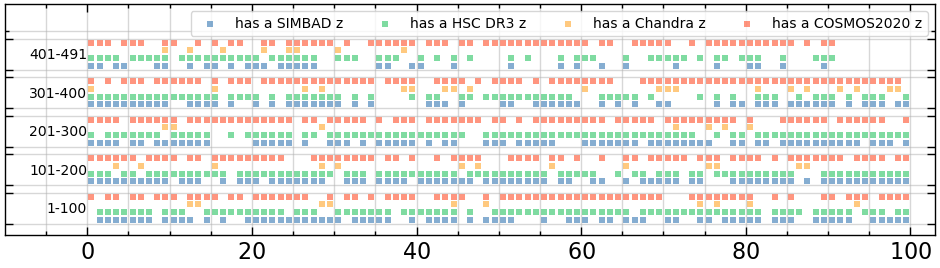

In [143]:
plt.figure(figsize=[12, 3])

ID = data_agn_updated['ID']
mask_simbad = data_agn_updated['z0']!=-1.
plt.scatter(((ID-1)%100+0.5)[mask_simbad], ((ID-1)//100+0.1)[mask_simbad], linewidths=0, alpha=0.5, s=20, marker='s', label='has a SIMBAD z')
mask_hsc = data_agn_updated['z1']!=-1.
plt.scatter(((ID-1)%100+0.5)[mask_hsc], ((ID-1)//100+0.1+0.2)[mask_hsc], linewidths=0, alpha=0.5, s=20, marker='s', label='has a HSC DR3 z')
mask_chandra = data_agn_updated['z5']!=-1.
plt.scatter(((ID-1)%100+0.5)[mask_chandra], ((ID-1)//100+0.1+0.4)[mask_chandra], linewidths=0, alpha=0.5, s=20, marker='s', label='has a Chandra z')
mask_cosmos = data_agn_updated['z3']!=-1.
plt.scatter(((ID-1)%100+0.5)[mask_cosmos], ((ID-1)//100+0.1+0.6)[mask_cosmos], linewidths=0, alpha=0.5, s=20, marker='s', label='has a COSMOS2020 z')

plt.legend(frameon=True, ncol=4, fontsize=10)
plt.text(-0, 0.4, '1-100', size=10, ha='right', va='center')
plt.text(-0, 1.4, '101-200', size=10, ha='right', va='center')
plt.text(-0, 2.4, '201-300', size=10, ha='right', va='center')
plt.text(-0, 3.4, '301-400', size=10, ha='right', va='center')
plt.text(-0, 4.4, '401-491', size=10, ha='right', va='center')
plt.xlim(-10, 103)
plt.ylim(-0.3, 5.7)

plt.yticks([0, 0.8, 1, 1.8, 2, 2.8, 3, 3.8, 4, 4.8], '')
plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(1))
plt.grid(which='major', alpha=0.5)
plt.grid(which='minor', alpha=0.5)

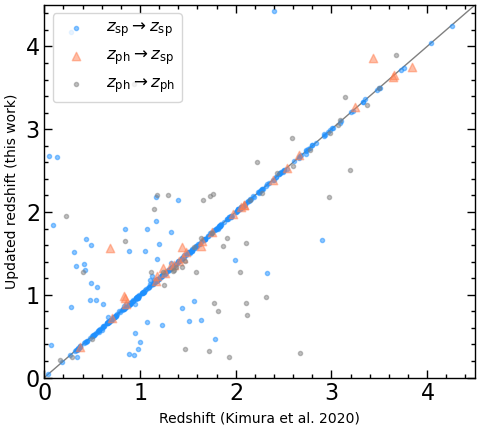

In [144]:
fig, ax = plt.subplots(1,1, figsize=(5, 4.5))

# mask_unchanged = (data_agn_updated['r_z']==4)
# ax.scatter(data_agn_updated['z4'][mask_unchanged], data_agn_updated['z'][mask_unchanged], 
#            marker='.', color='gray', label=r'unchanged', alpha=0.5)

mask_sp_before = (data_agn_updated['r_z4']<=2) | (data_agn_updated['z5']!=-1.)
mask_sp_after = np.isin(data_agn_updated['r_z'], [0, 1, 5])

mask_sp2sp = mask_sp_before & mask_sp_after
ax.scatter(data_agn_updated['z4'][mask_sp2sp], data_agn_updated['z'][mask_sp2sp], 
           marker='.', color='dodgerblue', label=r'$z_{\rm sp} \rightarrow z_{\rm sp}$', alpha=0.5)

mask_ph2sp = (~mask_sp_before) & mask_sp_after
ax.scatter(data_agn_updated['z4'][mask_ph2sp], data_agn_updated['z'][mask_ph2sp], 
           marker='^', color='coral', label=r'$z_{\rm ph} \rightarrow z_{\rm sp}$', alpha=0.5)

mask_ph2ph = (~mask_sp_before) & (~mask_sp_after)
ax.scatter(data_agn_updated['z4'][mask_ph2ph], data_agn_updated['z'][mask_ph2ph], 
           marker='.', color='gray', label=r'$z_{\rm ph} \rightarrow z_{\rm ph}$', alpha=0.5)

ax.plot([0, 4.5], [0, 4.5], lw=1, zorder=-2, color='gray')
ax.set_xlabel('Redshift (Kimura et al. 2020)')
ax.set_ylabel('Updated redshift (this work)')
ax.legend(frameon=True, loc=2, fontsize=12)
ax.set_xlim(0, 4.5)
ax.set_ylim(0, 4.5)
fig.savefig('specz.pdf', dpi=300)

fig.tight_layout()

manually check inconsistent zs


```
Original Chandra    -> z5
SIMBAD              -> z0
HSC DR3             -> z1
COSMOS2020          -> z3 -> not inspect (photz)
```

In [145]:
z_list = ['z0', 'z1', 'z5']
inconsistent_z = table.Table(names=(['ID']+z_list), dtype=([np.int64]+[np.float64]*len(z_list)))
for i in range(len(data_agn_updated)): 
    z = data_agn_updated[i][z_list]
    z_filtered = [j for j in z if j!=-1.]
    if z_filtered!=[]: 
        if np.max(z_filtered)-np.min(z_filtered)>0.1: 
            inconsistent_z.add_row(data_agn_updated[i][['ID'] + z_list])
            # print(data_agn_download[ID][['ID'] + z_list])
inconsistent_z.pprint_all()

 ID    z0        z1       z5 
--- ------- ----------- -----
 11   0.925      1.5652  -1.0
 17  1.2651      2.3219  -1.0
 27  0.9736       1.634  -1.0
 40  1.1433      0.4924  -1.0
 76  0.8913   1.5563668  -1.0
 90  1.2995  0.42066365  -1.0
103   1.606   0.4906261  -1.0
127   1.797   1.0733103  -1.0
137  2.1458     1.40008  -1.0
139  1.5145      1.9289  -1.0
145  0.9793      1.7592  -1.0
153   0.695    1.001973  -1.0
193   2.673 0.045087364  -1.0
197    0.34      1.9582  -1.0
201  1.8456 0.090319805  -1.0
206  0.4967      0.6911  -1.0
210  0.6312        -1.0 1.233
221  0.3236      0.7344  -1.0
223 0.74829      0.5773  -1.0
227  0.4586      1.5659  -1.0
237  2.6681  0.13425398  -1.0
256  1.4797   0.3996155  -1.0
257  0.4319   1.0107826  -1.0
270  1.7977   0.8445786  -1.0
273  0.4311       1.596  -1.0
276  0.4682        -1.0 1.782
292  0.5368   0.9435049  -1.0
300    4.17   0.2762015  -1.0
331  0.7284      2.2335  -1.0
367  0.7252      1.3247  -1.0
384  0.9388      1.3955  -1.0
400   0.94

### Photo-z comparison

TODO: Fix spec-z's that are really photo-z's and read hsc_agn_download.txt file.

Lephare includes AGN component. Even then, the photo-z's are rough

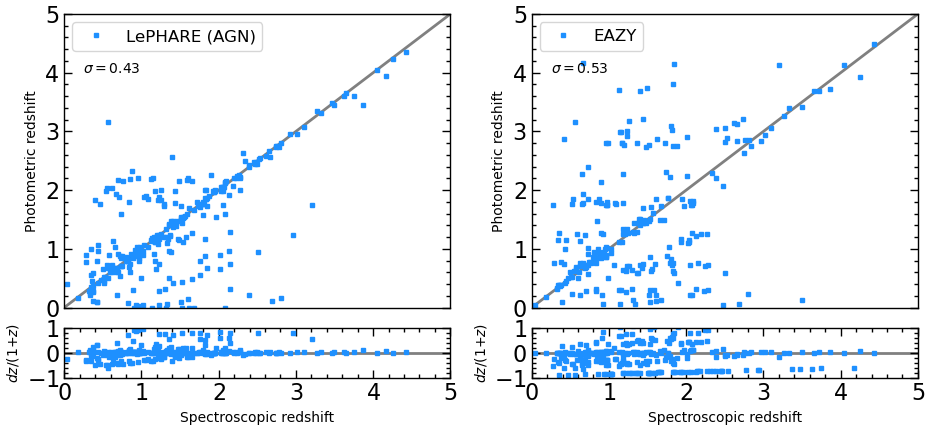

In [146]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

data_agn = ascii.read('hsc_agn.txt')
# data_agn_updated = ascii.read('hsc_agn_updated.txt')
cat_agn = SkyCoord(data_agn['RAdeg'], data_agn['DEdeg'], unit='deg')

z_updated = data_agn_updated['z'][idx_agn2COSMOS20]
mask_spec_updated = data_agn_updated['r_z'][idx_agn2COSMOS20] < 2

z_hsc = data_agn['z'][idx_agn2COSMOS20]

z_ez = data_cosmos2020['ez_z_phot'][idx_COSMOS20]
z_agn = data_cosmos2020['lp_zq'][idx_COSMOS20]
mask_spec = data_agn['r_z'][idx_agn2COSMOS20] < 2


fig, axs = plt.subplots(1,2, figsize=(9.5, 4.5))

axs[0].errorbar(z_updated[mask_spec_updated], z_agn[mask_spec_updated], color='dodgerblue',
            marker='s', ms=2.5, linestyle='none', label='LePHARE (AGN)')

axs[0].set_xlabel('Spectroscopic redshift')
axs[0].set_ylabel('Photometric redshift')


axs[0].legend(frameon=True, fontsize=12, loc=2)
axs[0].plot([-1, 5], [-1, 5], color='gray', zorder=-1)

axs[0].set_xlim(0, 5)
axs[0].set_ylim(0, 5)

divider = make_axes_locatable(axs[0])
ax12 = divider.append_axes("bottom", size=.5, pad=0.2)
axs[0].figure.add_axes(ax12)

res = (z_updated - z_agn)/(1 + z_agn)

ax12.errorbar(z_updated[mask_spec_updated], res[mask_spec_updated], color='dodgerblue',
            marker='s', ms=2.5, linestyle='none', label='EAZY')

ax12.plot([0, 5], [0, 0], color='gray', zorder=-1, label='y=x')

axs[0].get_xaxis().set_visible(False)

mask_outlier = z_ez < 5
axs[0].text(0.25, 4, f'$\sigma = {np.round(np.std(res[mask_spec_updated & mask_outlier]), 2)}$')


###

axs[1].errorbar(z_updated[mask_spec_updated], z_ez[mask_spec_updated], color='dodgerblue',
            marker='s', ms=2.5, linestyle='none', label='EAZY')

ax12.set_xlim(0, 5)
ax12.set_ylim(-1, 1)
ax12.set_xlabel('Spectroscopic redshift')

ax12.set_ylabel(r'$dz/(1{+}z)$')
axs[1].set_ylabel('Photometric redshift')

axs[1].legend(frameon=True, fontsize=12, loc=2)
axs[1].plot([-1, 5], [-1, 5], color='gray', zorder=-1, label='y=x')

axs[1].set_xlim(0, 5)
axs[1].set_ylim(0, 5)

axs[1].get_xaxis().set_visible(False)

divider = make_axes_locatable(axs[1])
ax22 = divider.append_axes("bottom", size=.5, pad=0.2)
axs[1].figure.add_axes(ax22)

res = (z_updated - z_ez)/(1 + z_ez)

ax22.errorbar(z_updated[mask_spec_updated], res[mask_spec_updated], color='dodgerblue',
            marker='s', ms=2.5, linestyle='none', label='EAZY')

ax22.plot([0, 5], [0, 0], color='gray', zorder=-1, label='y=x')

mask_outlier = z_ez < 5
axs[1].text(0.25, 4, f'$\sigma = {np.round(np.std(res[mask_spec_updated & mask_outlier]), 2)}$')


ax22.set_xlim(0, 5)
ax22.set_ylim(-1, 1)
ax22.set_ylabel(r'$dz/(1{+}z)$')
ax22.set_xlabel('Spectroscopic redshift')


fig.tight_layout()
fig.savefig('photoz.pdf', dpi=300)

Use LePHARE photo-z:

In [147]:
data_agn_updated['z_phot'] = -1.0

for j,i in enumerate(idx_agn2COSMOS20):
    if np.isfinite(z_agn[j]) and (z_agn[j] < 5):
        data_agn_updated['z_phot'][i] = z_agn[j]

Check if SIMBAD spec-z and Kiruma20 spec-z are consistent

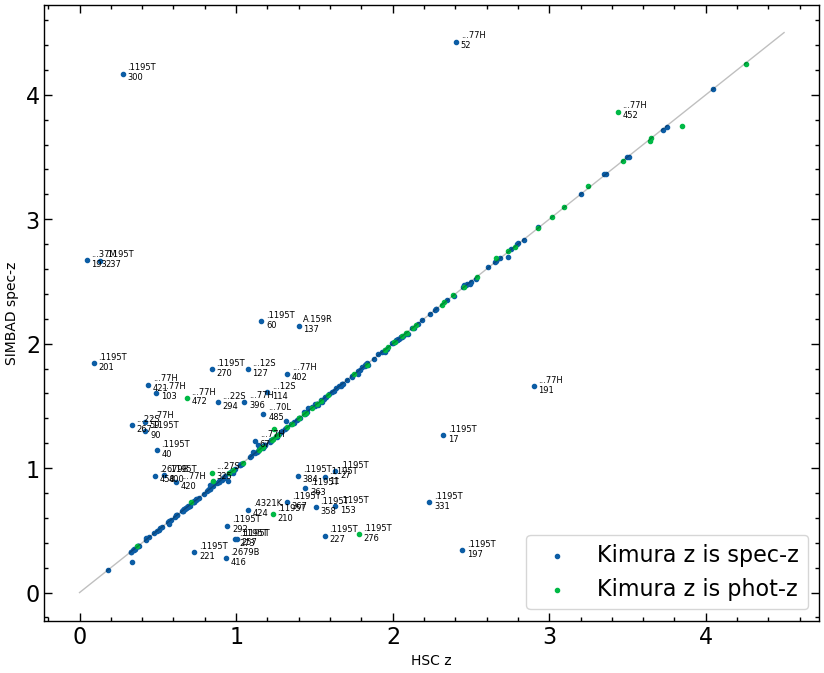

In [148]:
data_agn_compare = table.Table(data=[[0.]*491, ['none']*491, [0.]*491, ['-'*19]*491, [None]*491], 
                               names=['HSC-z', 'r_HSC-z', 'SIMBAD-z', 'bib_SIMBAD-z', 'name'])
for j,i in enumerate(idx_simbad_specz):
    if data_agn['r_z'][i] <= 2:
        data_agn_compare['r_HSC-z'][i] = 'spec'
    else: 
        data_agn_compare['r_HSC-z'][i] = 'phot'
    data_agn_compare['HSC-z'][i] = data_agn['z'][i]
    data_agn_compare['SIMBAD-z'][i] = result_table[mask_spec_simbad]['Z_VALUE'][j]
    data_agn_compare['bib_SIMBAD-z'][i] = result_table[mask_spec_simbad]['RVZ_BIBCODE'][j]
    data_agn_compare['name'][i] = result_table[mask_spec_simbad]['MAIN_ID'][j]

plt.figure(figsize=[10, 8])

plt.scatter(data_agn_compare['HSC-z'][data_agn_compare['r_HSC-z']=='spec'], 
            data_agn_compare['SIMBAD-z'][data_agn_compare['r_HSC-z']=='spec'], 
            marker='.', label='Kimura z is spec-z')
plt.scatter(data_agn_compare['HSC-z'][data_agn_compare['r_HSC-z']=='phot'], 
            data_agn_compare['SIMBAD-z'][data_agn_compare['r_HSC-z']=='phot'], 
            marker='.', label='Kimura z is phot-z')
# add bibcode to interested dots
for i, txt in enumerate(data_agn_compare['bib_SIMBAD-z']): #enumerate(np.arange(491)+1):
    if (np.abs(data_agn_compare['HSC-z'][i] - data_agn_compare['SIMBAD-z'][i])>0.1) : 
        plt.annotate(txt[13:], (data_agn_compare['HSC-z'][i]+0.03, data_agn_compare['SIMBAD-z'][i]+0.03), size=6)
        plt.annotate(i+1, (data_agn_compare['HSC-z'][i]+0.03, data_agn_compare['SIMBAD-z'][i]-0.05), size=6)
plt.plot([0, 4.5], [0, 4.5], '-k', linewidth=1, alpha=0.25)
plt.xlabel('HSC z')
plt.ylabel('SIMBAD spec-z')
plt.legend(frameon=True)
plt.show()


### Save updated table

In [149]:
table_header = profile.pformat_all(align='<')
data_agn_updated.meta['comments'] = table_header

data_agn_updated_export = data_agn_updated['ID', 'RAdeg', 'DEdeg', 'i-mag', 'X-flag', 'g-flag', 'r-flag', 'i-flag', 'z-flag', 'n-corr', 'ID-COSMOS2015', 'z', 'z_phot', 'z0', 'z1', 'z2', 'z3', 'z4', 'z5', 'r_z', 'r_z0', 'r_z1', 'r_z4', 'comment']
ascii.write(data_agn_updated_export, 'hsc_agn_updated.txt', format='rst', overwrite=True)
data_agn_updated_export

ID,RAdeg,DEdeg,i-mag,X-flag,g-flag,r-flag,i-flag,z-flag,n-corr,ID-COSMOS2015,z,z_phot,z0,z1,z2,z3,z4,z5,r_z,r_z0,r_z1,r_z4,comment
--,deg,deg,mag,--,--,--,--,--,--,--,--,,,,,,--,,--,,,--,
int32,float64,float64,float64,int32,int32,int32,int32,int32,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,int32,int32,str50
1,150.74386,2.20245,22.71,1,1,1,1,1,6,594392,1.58,1.58,-1.0,-1.0,-1.0,1.58,1.561,-1.0,3,-1,-1,3,
2,150.73557,2.19957,20.36,1,1,1,1,1,6,592797,3.5026,-1.0,3.5026,3.503096,-1.0,-1.0,3.499,-1.0,0,7,3,1,
3,150.73353,2.15646,20.88,1,1,1,1,1,6,565402,0.979,1.03,0.979,0.9769,-1.0,1.03,0.977,-1.0,0,3,1,1,
4,150.79702,2.13888,21.01,1,1,1,1,1,6,552225,0.5727,0.51,0.5727,0.5727,-1.0,0.51,0.573,-1.0,0,16,5,1,
5,150.78259,2.19306,20.63,1,1,1,1,1,6,589540,0.5824,-1.0,0.5824,0.5847,-1.0,-1.0,0.585,-1.0,0,3,5,1,
6,150.72019,2.24803,21.13,1,1,1,1,1,6,625595,0.6652,0.62,0.6652,0.6633,-1.0,0.62,0.664,-1.0,0,3,1,1,
7,150.78838,2.34399,19.82,1,1,1,1,1,6,689768,1.9555,2.0,1.9555,1.964449,-1.0,2.0,1.964,-1.0,0,3,3,1,
8,150.71511,2.48483,19.2,1,1,1,1,1,6,782508,2.0051,-1.0,2.0051,1.995,-1.0,-1.0,1.999,-1.0,0,3,1,1,


In [150]:
data_agn_updated_export[data_agn_updated_export['ID']==227]

ID,RAdeg,DEdeg,i-mag,X-flag,g-flag,r-flag,i-flag,z-flag,n-corr,ID-COSMOS2015,z,z_phot,z0,z1,z2,z3,z4,z5,r_z,r_z0,r_z1,r_z4,comment
--,deg,deg,mag,--,--,--,--,--,--,--,--,,,,,,--,,--,,,--,
int32,float64,float64,float64,int32,int32,int32,int32,int32,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,int32,int32,str50
227,149.79179,1.87287,22.21,1,1,1,1,1,6,383384,1.5668,1.52,0.4586,1.5659,-1.0,1.52,1.566,-1.0,9,3,1,1,use zCOSMOS spec
